## Comparison between xmask and pymask machines

### Imports modules

In [6]:
import numpy as np
import xtrack as xt
import xpart as xp
import pandas as pd
import json
import matplotlib.pyplot as plt

# Plotting function
from plotting_functions import plot_all

# Plotly renderer
import plotly.io as pio

# ! Renderer should be set to 'notebook' or 'vscode' (depending on the IDE used) for interactive plots
pio.renderers.default = "browser"

### Build pymask line

In [7]:
path = "pymask/xsuite_lines/line_bb_for_tracking.json"
with open(path) as fid:
    dd = json.load(fid)
p_co = xp.Particles.from_dict(dd["particle_on_tracker_co"])
pm_line = xt.Line.from_dict(dd)
pm_line.particle_ref = xp.Particles.from_dict(dd["particle_on_tracker_co"])
pm_line.build_tracker()

Done loading line from dict.           
Compiling ContextCpu kernels...


ff3deb49fb6a48bfad3b015d14e2bc24.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from ff3deb49fb6a48bfad3b015d14e2bc24.c:50:
/home/cdroin/miniconda3/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.


In [8]:
# for i, x in enumerate(pm_line.element_names):
#     if 'bb_ho' in x or 'bb_lr' in x:
#         print(x)

# for i, x in enumerate(pm_line.element_names):
#     if "bb_ho" in x or "bb_lr" in x:
#         print(x, pm_line.element_refs[x].scale_strength._value)

### Build xmask line

In [9]:
collider = xt.Multiline.from_json("xmask/xsuite_lines/collider_03_tuned_bb_on.json")
collider.build_trackers()

b1 = True
if b1:
    xm_line = collider["lhcb1"]
else:
    xm_line = collider["lhcb2"]

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Compiling ContextCpu kernels...


dfa2379594574005941f5ab9351c211e.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from dfa2379594574005941f5ab9351c211e.c:50:
/home/cdroin/miniconda3/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...


90871b0dc3f54bdb89567ef70ec16c5f.c:4280: warning: "_GNU_SOURCE" redefined
 4280 | #  define _GNU_SOURCE // enable GNU libc NAN extension if possible
      | 
In file included from 90871b0dc3f54bdb89567ef70ec16c5f.c:50:
/home/cdroin/miniconda3/include/python3.10/pyconfig.h:1621: note: this is the location of the previous definition
 1621 | #define _GNU_SOURCE 1
      | 


Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Compare elements in both lines

#### Check element names which differ


In [10]:
# Get element names in pymask and xmask
set_pm = set(pm_line.element_names)
set_xm = set(xm_line.element_names)

# Get elements in pymask but not in xmask
set_pm_not_xm = set_pm - set_xm
print("Elements in pymask but not in xmask", set_pm_not_xm)
print(
    "Elements in xmask but not in pymask that are not drifts",
    [x for x in set_pm_not_xm if "drift" not in x],
)

# Get elements in xmask but not in pymask
set_xm_not_pm = set_xm - set_pm
print("Elements in pymask but not in xmask", set_xm_not_pm)
print("Elements in pymask but not in xmask", [x for x in set_xm_not_pm if "drift" not in x])

Elements in pymask but not in xmask {'drift_11774', 'drift_11788', 'drift_8726', 'drift_11947', 'drift_2865', 'drift_11955', 'drift_11849', 'drift_11961', 'drift_8864', 'drift_11791', 'drift_11923', 'drift_2797', 'drift_2910', 'drift_7205', 'drift_11906', 'drift_11787', 'drift_11861', 'drift_11867', 'drift_11792', 'drift_11927', 'drift_11942', 'drift_10221', 'drift_11907', 'drift_11987', 'drift_11953', 'drift_8849', 'drift_10258', 'drift_7242', 'drift_11914', 'drift_7072', 'drift_11770', 'drift_11780', 'drift_11853', 'drift_11912', 'drift_2919', 'drift_8690', 'drift_10294', 'drift_7236', 'drift_11798', 'drift_11805', 'drift_10336', 'drift_2862', 'drift_11868', 'drift_7079', 'drift_2858', 'drift_8705', 'drift_11773', 'drift_11818', 'drift_10348', 'drift_11945', 'drift_2861', 'drift_10310', 'drift_11793', 'drift_11878', 'drift_11809', 'drift_11781', 'drift_11873', 'drift_11948', 'drift_2723', 'drift_2727', 'drift_8584', 'drift_10307', 'drift_11802', 'drift_11901', 'drift_10392', 'drift_2

#### Check if some dipoles differ


In [11]:
dipole_names = [x for x in pm_line.element_names if "mb" in x]
for i, dipole in enumerate(dipole_names):
    class_element = pm_line[dipole].to_dict()["__class__"]
    if class_element != "Marker" and class_element != "Drift":
        try:
            if class_element == "SRotation":
                assert pm_line[dipole].cos_z == xm_line[dipole].cos_z
                assert pm_line[dipole].sin_z == xm_line[dipole].sin_z
                assert pm_line[dipole].angle == xm_line[dipole].angle
            else:
                assert pm_line[dipole].length == xm_line[dipole].length
                assert pm_line[dipole].hxl == xm_line[dipole].hxl
                assert pm_line[dipole].hyl == xm_line[dipole].hyl
                assert pm_line[dipole].knl[0] == xm_line[dipole].knl[0]
                assert pm_line[dipole].ksl[0] == xm_line[dipole].ksl[0]
        except:
            try:
                print("PM", dipole, pm_line[dipole].to_dict())
            except Exception as e:
                print(e)
            try:
                print("XM", dipole, xm_line[dipole].to_dict())
            except Exception as e:
                print(e)

#### Check if some multipoles differ 

In [12]:
def check_difference_multipoles(multipole_names, index_strength):
    for i, multipole in enumerate(multipole_names):
        class_element = pm_line[multipole].to_dict()["__class__"]
        if class_element != "Marker" and class_element != "Drift":
            try:
                assert pm_line[multipole].length == xm_line[multipole].length
                assert pm_line[multipole].hxl == xm_line[multipole].hxl
                assert pm_line[multipole].hyl == xm_line[multipole].hyl
                assert np.allclose(
                    pm_line[multipole].knl[index_strength], xm_line[multipole].knl[index_strength]
                )
                assert np.allclose(
                    pm_line[multipole].ksl[index_strength], xm_line[multipole].ksl[index_strength]
                )
            except:
                try:
                    print("PM", multipole, pm_line[multipole].to_dict())
                except Exception as e:
                    print(e)
                try:
                    print("XM", multipole, xm_line[multipole].to_dict())
                except Exception as e:
                    print(e)

In [13]:
# Quadrupoles
quadrupole_names = [x for x in pm_line.element_names if "mq" in x]
check_difference_multipoles(quadrupole_names, 1)

PM mqt.14r3.b1..1 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.0000000e+00, -1.3400381e-05]), 'ksl': array([0., 0.])}
XM mqt.14r3.b1..1 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.00000000e+00, -1.33676663e-05]), 'ksl': array([0., 0.])}
PM mqt.14r3.b1..2 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.0000000e+00, -1.3400381e-05]), 'ksl': array([0., 0.])}
XM mqt.14r3.b1..2 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.00000000e+00, -1.33676663e-05]), 'ksl': array([0., 0.])}
PM mqt.15r3.b1..1 {'__class__': 'Multipole', 'order': 1, 'inv_factorial_order': 1.0, 'length': 0.16, 'hxl': 0.0, 'hyl': 0.0,

In [14]:
# Sextupoles
sextupole_names = [x for x in pm_line.element_names if "ms" in x]
check_difference_multipoles(sextupole_names, 2)

PM ms.11r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([0.        , 0.        , 0.02859793]), 'ksl': array([0., 0., 0.])}
XM ms.11r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([0.        , 0.        , 0.02854926]), 'ksl': array([0., 0., 0.])}
PM ms.12r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.        ,  0.        , -0.05953488]), 'ksl': array([0., 0., 0.])}
XM ms.12r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl': 0.0, 'hyl': 0.0, 'radiation_flag': 0, 'knl': array([ 0.        ,  0.        , -0.05961634]), 'ksl': array([0., 0., 0.])}
PM ms.13r3.b1 {'__class__': 'Multipole', 'order': 2, 'inv_factorial_order': 0.5, 'length': 0.369, 'hxl

In [15]:
# Octupoles
octupole_names = [x for x in pm_line.element_names if "mo" in x]
check_difference_multipoles(octupole_names, 3)

### Check that main observables are the same

In [16]:
#tw_xm_1 = collider["lhcb1"].twiss()
tw_xm_1 = collider["lhcb1"].twiss()
tw_pm_1 = pm_line.twiss()

In [17]:
print("Tune pymask x:", tw_pm_1.qx)
print("Tune xmask x:", tw_xm_1.qx)
print()
print("Tune pymask y:", tw_pm_1.qy)
print("Tune xmask y:", tw_xm_1.qy)
print()
print("Chromaticity pymask x:", tw_pm_1.dqx)
print("Chromaticity xmask x:", tw_xm_1.dqx)
print()
print("Chromaticity pymask y:", tw_pm_1.dqy)
print("Chromaticity xmask y:", tw_xm_1.dqy)
print()
print("Linear coupling pymask:", tw_pm_1.c_minus)
print("Linear coupling xmask:", tw_xm_1.c_minus)


Tune pymask x: 62.2931994570473
Tune xmask x: 62.29779991484583

Tune pymask y: 60.299325010881724
Tune xmask y: 60.30377860745952

Chromaticity pymask x: 14.13642468584747
Chromaticity xmask x: 21.727617552618206

Chromaticity pymask y: 11.635070201314601
Chromaticity xmask y: 11.461830350905089

Linear coupling pymask: 0.0010102096810129433
Linear coupling xmask: 0.002707345690182369


In [18]:
for ip in [1,2,5,8]:
    print("Pymask", tw_pm_1.rows[f'ip{ip}'].cols['s', 'x', 'px', 'y', 'py'].to_pandas())
    print("Xmask", tw_xm_1.rows[f'ip{ip}'].cols['s', 'x', 'px', 'y', 'py'].to_pandas())
    print()

Pymask   name           s             x       px             y            py
0  ip1  19994.1624 -9.044715e-08  0.00025 -1.112296e-08  2.704947e-07
Xmask   name           s             x       px             y            py
0  ip1  19994.1624 -9.057173e-08  0.00025 -1.162994e-08  2.684610e-07

Pymask   name             s         x            px             y      py
0  ip2  23326.598984 -0.000138  2.224991e-07 -8.913028e-08 -0.0001
Xmask   name             s         x            px             y      py
0  ip2  23326.598984 -0.000145  2.239101e-07 -8.545627e-08 -0.0001

Pymask   name            s             x            px             y       py
0  ip5  6664.568433  7.117981e-08  1.363571e-07 -2.401351e-08  0.00025
Xmask   name            s             x            px             y       py
0  ip5  6664.568433  6.977915e-08  1.335215e-07 -2.479279e-08  0.00025

Pymask   name             s             x        px             y        py
0  ip8  16650.658184 -3.109192e-07  0.000135 -3.20

### Replace the pymaks bb values with the xmask ones

In [19]:
# ! Probably no applicable if levelling in pymask and not in xmask
for x in collider.lhcb1.element_dict:#collider.lhcb1.element_dict:
    dic_el = collider.lhcb1.element_dict[x].to_dict()
    if "bb" in x and dic_el['__class__']!='Drift':
        for key in dic_el:
            if key!='__class__':
                try:
                    setattr(pm_line.element_refs[x], key, dic_el[key])
                except Exception as e:
                    print(e)

tw_pm_1 = pm_line.twiss()


In [20]:
tw_xm_1 = collider["lhcb1"].twiss()
tw_pm_1 = pm_line.twiss()

print("Tune pymask x:", tw_pm_1.qx)
print("Tune xmask x:", tw_xm_1.qx)
print()
print("Tune pymask y:", tw_pm_1.qy)
print("Tune xmask y:", tw_xm_1.qy)
print()
print("Chromaticity pymask x:", tw_pm_1.dqx)
print("Chromaticity xmask x:", tw_xm_1.dqx)
print()
print("Chromaticity pymask y:", tw_pm_1.dqy)
print("Chromaticity xmask y:", tw_xm_1.dqy)
print()
print("Linear coupling pymask:", tw_pm_1.c_minus)
print("Linear coupling xmask:", tw_xm_1.c_minus)

Tune pymask x: 62.29547924009748
Tune xmask x: 62.29779991484583

Tune pymask y: 60.30122970450527
Tune xmask y: 60.30377860745952

Chromaticity pymask x: 25.40333550602486
Chromaticity xmask x: 21.727617552618206

Chromaticity pymask y: 14.61982895892222
Chromaticity xmask y: 11.461830350905089

Linear coupling pymask: 0.001463951345168006
Linear coupling xmask: 0.002707345690182369


In [21]:
# Deactivate bb and see how values change
collider.vars['beambeam_scale'] = 0

# Set knob for 'on_bb_charge' for pymask
for i, x in enumerate(tw_pm_1.to_pandas().name):
    if "bb_lr" in x or "bb_ho" in x:
        pm_line.element_refs[x].scale_strength = pm_line.vars["on_bb_charge"]

pm_line.vars["on_bb_charge"] = 0

tw_xm_1 = collider["lhcb1"].twiss()
tw_pm_1 = pm_line.twiss()

print("Tune pymask x:", tw_pm_1.qx)
print("Tune xmask x:", tw_xm_1.qx)
print()
print("Tune pymask y:", tw_pm_1.qy)
print("Tune xmask y:", tw_xm_1.qy)
print()
print("Chromaticity pymask x:", tw_pm_1.dqx)
print("Chromaticity xmask x:", tw_xm_1.dqx)
print()
print("Chromaticity pymask y:", tw_pm_1.dqy)
print("Chromaticity xmask y:", tw_xm_1.dqy)
print()
print("Linear coupling pymask:", tw_pm_1.c_minus)
print("Linear coupling xmask:", tw_xm_1.c_minus)

# Reactive bb
collider.vars['beambeam_scale'] = 1
pm_line.vars["on_bb_charge"] = 1



Tune pymask x: 62.316064434977406
Tune xmask x: 62.31600064578007

Tune pymask y: 60.3210565086476
Tune xmask y: 60.32100070502017

Chromaticity pymask x: 14.994065932961709
Chromaticity xmask x: 14.996053091267669

Chromaticity pymask y: 15.001771845498945
Chromaticity xmask y: 14.998334018057335

Linear coupling pymask: 0.0009809750762181822
Linear coupling xmask: 3.451011241592523e-05


In [22]:
# Update linear coupling as well
print([x for x in list(collider.vars._get_value().items()) if "c_minus" in x[0]])

c_minus_re_b1_before_correction = collider.vars['c_minus_re_b1']._value
c_minus_re_b2_before_correction = collider.vars['c_minus_re_b2']._value
c_minus_im_b1_before_correction = collider.vars['c_minus_im_b1']._value
c_minus_im_b2_before_correction = collider.vars['c_minus_im_b2']._value

cmrskew = pm_line.vars['cmrskew']._value
cmiskew = pm_line.vars['cmiskew']._value

collider.vars['c_minus_re_b1'] += 0.001
collider.vars['c_minus_re_b2'] += 0.001

print(collider.vars['c_minus_re_b1']._get_value())

tw_xm_1 = collider["lhcb1"].twiss()
tw_xm_2 = collider["lhcb2"].twiss()

print(tw_xm_1.c_minus, tw_xm_2.c_minus)

[('c_minus_re_b1', 0.0), ('c_minus_im_b1', 0.0), ('c_minus_re_b2', 0.0), ('c_minus_im_b2', 0.0)]
0.001
0.003318407179126853 0.004236506133218374


### Plot everything in an interactive widget

In [23]:
fig = plot_all(tw_pm_1, tw_xm_1, tw_xm_2)

fig.write_html("widgets/widget.html", config = {'displayModeBar': False})
fig.show(config = {'displayModeBar': False})

### Plot footprint again

0.0012388745030619864
0.002707345690182369
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


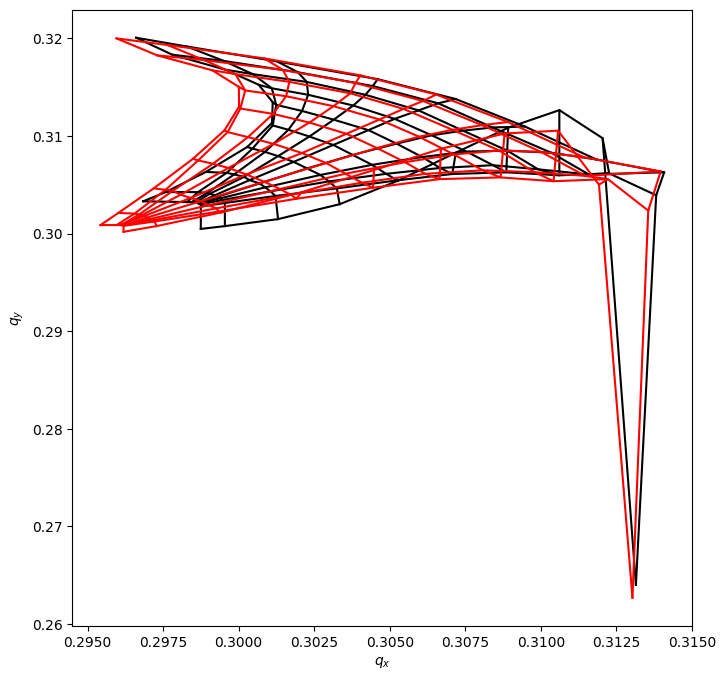

In [24]:
# Temporary remove coupling to get a better footprint
collider.vars['c_minus_re_b1'] = 0
collider.vars['c_minus_re_b2'] = 0
collider.vars['c_minus_im_b1'] = 0
collider.vars['c_minus_im_b2'] = 0
pm_line.vars['cmrskew'] = 0
pm_line.vars['cmiskew'] = 0

### CHECK
tw_pm_1 = pm_line.twiss()
tw_xm_1 = collider["lhcb1"].twiss()

print(tw_pm_1.c_minus)
print(tw_xm_1.c_minus)

# Plot footprint
fp_polar_xm = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1/2)],
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fp_polar_xm.plot(ax=ax, label="no rescale bb")
#plt.suptitle("Polar mode (default) - no rescale on beambeam. Xmask.")
#plt.show()


fp_polar = pm_line.get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="on_bb_charge", v0=0.0, dv=0.1/2)],
)

#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fp_polar.plot(ax=ax, label="no rescale bb", color = 'red')
#plt.suptitle("Polar mode (default)")
plt.show()

# Set back coupling
collider.vars['c_minus_re_b1'] = c_minus_re_b1_before_correction + 0.001
collider.vars['c_minus_re_b2'] = c_minus_re_b2_before_correction + 0.001
collider.vars['c_minus_im_b1'] = c_minus_im_b1_before_correction 
collider.vars['c_minus_im_b2'] = c_minus_im_b2_before_correction 
pm_line.vars['cmrskew'] = cmrskew
pm_line.vars['cmiskew'] = cmiskew

tw_pm_1 = pm_line.twiss()
tw_xm_1 = collider["lhcb1"].twiss()



0.001463951345168006
0.003318407179126853
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.
Tracking particles for footprint...
Done tracking.
Computing footprint...
Done computing footprint.


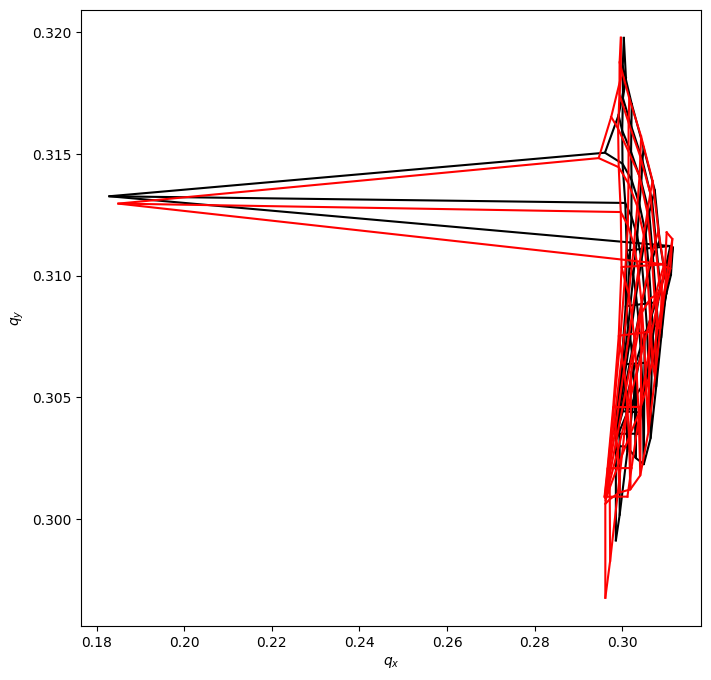

In [25]:
### Same as before without touching coupling knobs
### CHECK c_minus first
print(tw_pm_1.c_minus)
print(tw_xm_1.c_minus)

# Plot footprint
fp_polar_xm = collider["lhcb1"].get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="beambeam_scale", v0=0.0, dv=0.1/2)],
)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fp_polar_xm.plot(ax=ax, label="no rescale bb")
#plt.suptitle("Polar mode (default) - no rescale on beambeam. Xmask.")
#plt.show()


fp_polar = pm_line.get_footprint(
    nemitt_x=2.5e-6,
    nemitt_y=2.5e-6,
    linear_rescale_on_knobs=[xt.LinearRescale(knob_name="on_bb_charge", v0=0.0, dv=0.1/2)],
)

#fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fp_polar.plot(ax=ax, label="no rescale bb", color = 'red')
#plt.suptitle("Polar mode (default)")
plt.show()